In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# DESIGNING A CUSTOM CNN

# This model expects a 320x320 pixel greyscale image

class CNN_MAX(nn.Module):
    def __init__(self):
        super().__init__()
        
        #defining the paramteres of our model
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, padding = 2) #first convolution layer
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #pooling step
        
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, padding = 2)# second convolution layer
        
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels =32 , out_channels = 64, kernel_size =5, padding = 2 ) # third convolution layer
        
        self.bn3 = nn.BatchNorm2d(64)
        
       
        
        self.conv5 = nn.Conv2d(in_channels =64 , out_channels = 128, kernel_size =3, padding =1 ) # fourth convolution layer
        
        self.bn5 = nn.BatchNorm2d(128)
        
        self.conv6 = nn.Conv2d(in_channels =128 , out_channels = 256, kernel_size =3, padding =1 ) # fifth convolution layer
        
        self.bn6 = nn.BatchNorm2d(256)
        
        self.fc1 = nn.Linear(256*10*10,256)
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256,3) ## 3 channel output as we need to classify if it is node, cusp or smooth
        
        
    def forward(self, x):                      # denotes the shape of the tensor in each step
        x = F.relu(self.bn1(self.conv1(x)))
        x=self.pool(x)                         # [B,16,160,160]  
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)                       # [B, 32, 80, 80]

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)                       # [B, 64, 40, 40]

        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(x)                       # [B, 128, 20, 20]

        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)                       # [B, 256, 10, 10]
         
        
        x = x.view(-1, 256 * 10 * 10)
        x = F.relu(self.fc1(x))
        
        x= self.dropout(x)
        
        x = self.fc2(x)
        
      
        return x
    
    

In [4]:
transform= transforms.Compose([
    transforms.Grayscale(num_output_channels = 1),
    transforms.Resize((320,320)), # Resize to match model input
    transforms.ToTensor(),  # Converts to tensor and scales [0,255] → [0,1]
])

full_dataset = datasets.ImageFolder(root = 'trained_data_(csv_in_order_)/Visible_node_and_cusps/train_data_5/rescaled_data', transform = transform)

full_dataset.class_to_idx

{'cuspidal_curves_rescaled_CNN': 0,
 'nodal_curves_rescaled_CNN': 1,
 'smooth_curves_rescaled_CNN': 2}

In [5]:
model = CNN_MAX()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [17]:
# splitting data into train/validation sets (80-20)

train_size = int(0.8*len(full_dataset))
val_size = len(full_dataset)-train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
## training and validation loop

epochs = 30

best= float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    
 # Optimizing step   

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_correct = 0

    #Validation step
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"  Val   Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")  
    if avg_val_loss<best:
        torch.save(model.state_dict(), f"cnn_max.pth")
        print(f"> Saved best model at epoch {epoch+1} with val loss {avg_val_loss:.4f}")
        best = avg_val_loss
        
    

Epoch 1/30
  Train Loss: 0.5680, Accuracy: 0.7786
  Val   Loss: 0.5003, Accuracy: 0.7989
> Saved best model at epoch 1 with val loss 0.5003
Epoch 2/30
  Train Loss: 0.5146, Accuracy: 0.7931
  Val   Loss: 0.6441, Accuracy: 0.7685
Epoch 3/30
  Train Loss: 0.4784, Accuracy: 0.8075
  Val   Loss: 0.5857, Accuracy: 0.7515
Epoch 4/30
  Train Loss: 0.4647, Accuracy: 0.8090
  Val   Loss: 0.4474, Accuracy: 0.8378
> Saved best model at epoch 4 with val loss 0.4474
Epoch 5/30
  Train Loss: 0.4274, Accuracy: 0.8269
  Val   Loss: 1.7898, Accuracy: 0.6085
Epoch 6/30
  Train Loss: 0.4230, Accuracy: 0.8319
  Val   Loss: 0.6753, Accuracy: 0.8081
Epoch 7/30
  Train Loss: 0.4088, Accuracy: 0.8327
  Val   Loss: 1.5070, Accuracy: 0.6500
Epoch 8/30
  Train Loss: 0.4025, Accuracy: 0.8330
  Val   Loss: 0.8994, Accuracy: 0.7137
Epoch 9/30
  Train Loss: 0.3753, Accuracy: 0.8474
  Val   Loss: 1.6373, Accuracy: 0.6396


KeyboardInterrupt: 

# Testing Phase Below
## We will test and use a confusion matrix to see the performance

In [6]:
test_dataset = datasets.ImageFolder(root = 'testing_set/test_data', transform = transform)

In [7]:
test_dataset.class_to_idx


{'cuspidal_curves_rescaled_CNN': 0,
 'nodal_curves_rescaled_CNN': 1,
 'smooth_curves_rescaled_CNN': 2}

In [8]:
model.load_state_dict(torch.load("cnn_max.pth"))

C:\Users\sushe\AppData\Local\Temp\ipykernel_13804\1777921927.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_max.pth"))


<All keys matched successfully>

  Test   Loss: 0.3668, Accuracy: 0.8760


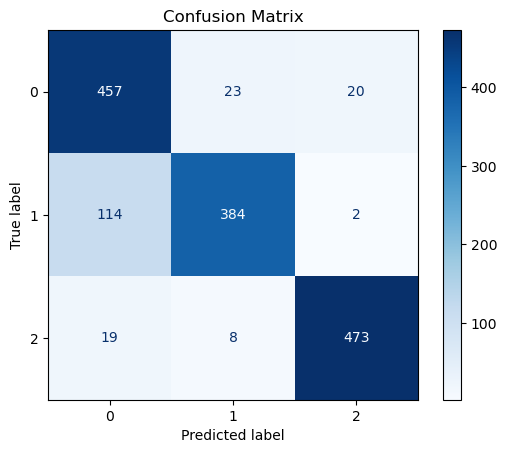

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter


all_preds = []
all_labels = []

model.eval()
test_loss = 0.0
test_correct = 0
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Testing Step

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        

avg_test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct / len(test_loader.dataset)
print(f"  Test   Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

#  Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
